In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history


import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


Récupération du dataframe précédemment préparé.

In [4]:
img_dir = 'Flipkart/Images/'
l_cat = ['Home Furnishing', 'Baby Care', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Watches', 'Kitchen & Dining', 'Computers']

data = pd.read_csv('dataframe_pictures.csv')
data.head()

,product_category_tree,image
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


Split entre un training set (80%) et un test set (20%).

In [5]:
data_train, data_test = train_test_split(data, stratify=data['product_category_tree'], test_size=0.20, random_state=42)
data_train.reset_index(inplace=True, drop=True)
data_test.reset_index(inplace=True, drop=True)
print(f'data_train : {data_train.shape}')
print(f'data_test : {data_test.shape}')

data_train : (840, 2)
data_test : (210, 2)


La méthode utilisée a besoin que les images soient au préalable réparties dans des dossiers selon leurs classes.  
Je sépare également le training set du test set.  

In [6]:
import shutil

# Creating Train / Test folders
if os.path.exists(img_dir + '/train//' + l_cat[0]):
    print('Directories already exist')
else:  
    for categ in l_cat:
        os.makedirs(img_dir + '/train//' + categ)
        os.makedirs(img_dir + '/test//' + categ)
    
    for index, row in data_train.iterrows():
        shutil.copy(img_dir + str(row['image']), img_dir + '/train//' + str(row['product_category_tree']))
        
    for index, row in data_test.iterrows():
        shutil.copy(img_dir + str(row['image']), img_dir + '/test//' + str(row['product_category_tree']))

Directories already exist


Utilisation de la fonction image_dataset_from_directory pour récupèrer les images.

In [7]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

Je sépare également le training set crée précédemment entre un training set (75%) et un validation set (25%).

In [8]:
path_train = "Flipkart/Images/train/"
path_test = "Flipkart/Images/test/"

dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


# Création du modèle basé sur VGG-16

Voici le modèle de base VGG-16 sans la sortie (les 1000 classes) et sans les 3 derniers layers qui consituent le réseau de neurones denses "classiques".  
Nous allons l'adapter à notre besoin.

In [9]:
model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Sans Data Augmentation

La fonction qui créée le modèle : 
- On récupère le modèle de base pré-entrainé et on fait en sorte que les couches de ce modèle ne s'entrainent pas.
- On rajoute notre sortie qui sera constituée d'un GlobalAveragePooling2D(), une nouvelle couche de 256 neuronnes, un dropout de 0.5 pour éviter le sur-apprentissage et enfin une dernière couche qui aura 7 sorties correspondant à nos 7 catégories.
- Enfin, on compile le modèle. La fonction de perte sera categorical_crossentropy et l'optimiseur adam.

In [25]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model_base.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model_base.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model_base.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

On utilise la fonction précédente pour créer notre modèle et on crée le callback avec un checkpoint qui se base sur la val_loss minimale.

In [26]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_no_DA = create_model_fct()

# Création du callback
model_no_DA_save_path = "./model_no_DA_best_weights.h5"
checkpoint = ModelCheckpoint(model_no_DA_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   


On entraine notre modèle sur le training set.

In [12]:
with tf.device('/gpu:0'): 
    history_no_DA = model_no_DA.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 6.1635 - accuracy: 0.4825
Epoch 1: val_loss improved from inf to 1.62651, saving model to .\model_no_DA_best_weights.h5
20/20 [==============================] - 15s 374ms/step - loss: 6.1635 - accuracy: 0.4825 - val_loss: 1.6265 - val_accuracy: 0.7333
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.2215 - accuracy: 0.6651
Epoch 2: val_loss improved from 1.62651 to 1.26050, saving model to .\model_no_DA_best_weights.h5
20/20 [==============================] - 3s 128ms/step - loss: 2.2215 - accuracy: 0.6651 - val_loss: 1.2605 - val_accuracy: 0.7429
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.4486 - accuracy: 0.7143
Epoch 3: val_loss improved from 1.26050 to 1.08827, saving model to .\model_no_DA_best_weights.h5
20/20 [==============================] - 3s 127ms/step - loss: 1.4486 - accuracy: 0.7143 - val_loss: 1.0883 - val_accuracy: 0.7857
Epoch 4/50
20/20 [================

Si on prend les modèle avec les paramètres finaux, on a une précision de 99% sur le training set et de 78% sur le validation set.

In [13]:
# Score du dernier epoch

loss, accuracy = model_no_DA.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_no_DA.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 2s 82ms/step - loss: 0.0477 - accuracy: 0.9889
Training Accuracy   : 0.9889

7/7 [==============================] - 1s 69ms/step - loss: 0.9895 - accuracy: 0.7857
Validation Accuracy :  0.7857


Si on prend le meilleur modèle (qu'on charge via le checkpoint qu'on avait parametré), on a une précision de 80% sur le validation set et 73% sur le testing set.

In [15]:
# Score de l'epoch optimal

model_no_DA.load_weights(model_no_DA_save_path)

loss, accuracy = model_no_DA.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model_no_DA.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8000
Test Accuracy       :  0.7381


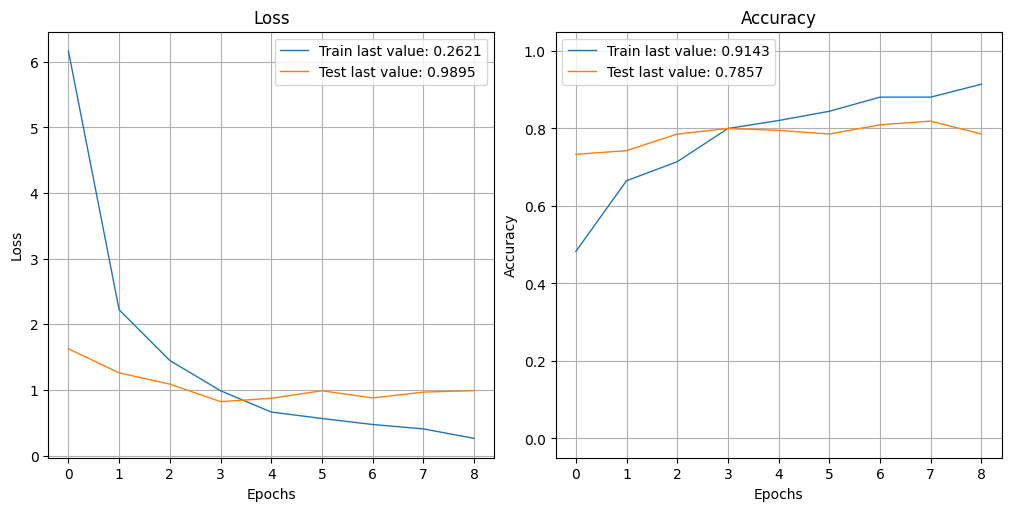

In [16]:
show_history(history_no_DA)
plot_history(history_no_DA, path="standard.png")
plt.close()

On voit que les résultats varient fortement entre le training set, le validation set et même le testing set.  
Cette variation est dûe au sur-apprentissage.  
Le data augmentation permet entre autre de palier ce problème.

## Avec Data Augmentation

La fonction qui créée le modèle : 
- On récupère le modèle de base pré-entrainé et on fait en sorte que les couches de ce modèle ne s'entrainent pas.
- On crée notre modèle en appliquant en premier une data augmentation à nos images en entrées.
- On redimensionne les pixels des images pour plus qu'ils soient entre [0, 255] mais entre [-1, 1] pour faciliter les calculs.
- On applique ici le modèle de base qu'on a récupéré auparavant.
- Et on rajoute notre sortie qui sera constituée d'un GlobalAveragePooling2D(), une nouvelle couche de 256 neuronnes, un dropout de 0.5 pour éviter le sur-apprentissage et enfin une dernière couche qui aura 7 sorties correspondant à nos 7 catégories.
- Enfin, on compile le modèle. La fonction de perte sera categorical_crossentropy et l'optimiseur adam.

In [28]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        #Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

On utilise la fonction précédente pour créer notre modèle et on crée le callback avec un checkpoint qui se base sur la val_loss minimale.

In [29]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_final = create_model_fct2()

# Création du callback
model_final_save_path = "./model_final_best_weights.h5"
checkpoint = ModelCheckpoint(model_final_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

On entraine notre modèle sur le training set.

In [30]:
with tf.device('/gpu:0'): 
    history = model_final.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9025 - accuracy: 0.2540
Epoch 1: val_loss improved from inf to 1.40770, saving model to .\model_final_best_weights.h5
20/20 [==============================] - 7s 234ms/step - loss: 1.9025 - accuracy: 0.2540 - val_loss: 1.4077 - val_accuracy: 0.6333
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4233 - accuracy: 0.5159
Epoch 2: val_loss improved from 1.40770 to 1.06644, saving model to .\model_final_best_weights.h5
20/20 [==============================] - 5s 237ms/step - loss: 1.4233 - accuracy: 0.5159 - val_loss: 1.0664 - val_accuracy: 0.7619
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1985 - accuracy: 0.5921
Epoch 3: val_loss improved from 1.06644 to 0.93192, saving model to .\model_final_best_weights.h5
20/20 [==============================] - 5s 229ms/step - loss: 1.1985 - accuracy: 0.5921 - val_loss: 0.9319 - val_accuracy: 0.7667
Epoch 4/50
20/20 [=================

Si on prend les modèle avec les paramètres finaux, on a une précision de 91% sur le training set et de 82% sur le validation set.

In [31]:
# Score du dernier epoch

loss, accuracy = model_final.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_final.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 2s 80ms/step - loss: 0.3460 - accuracy: 0.9048
Training Accuracy   : 0.9048

7/7 [==============================] - 1s 67ms/step - loss: 0.5425 - accuracy: 0.8048
Validation Accuracy :  0.8048


Si on prend le meilleur modèle (qu'on charge via le checkpoint qu'on avait parametré), on a une précision de 82% encore sur le validation set et 77% sur le testing set.  

In [32]:
# Score de l'epoch optimal

model_final.load_weights(model_final_save_path)

loss, accuracy = model_final.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model_final.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8238
Test Accuracy       :  0.7667


Et voici le plot qui montre l'évolution du modèle sur le training_set et le validation_set (nommé test ici).

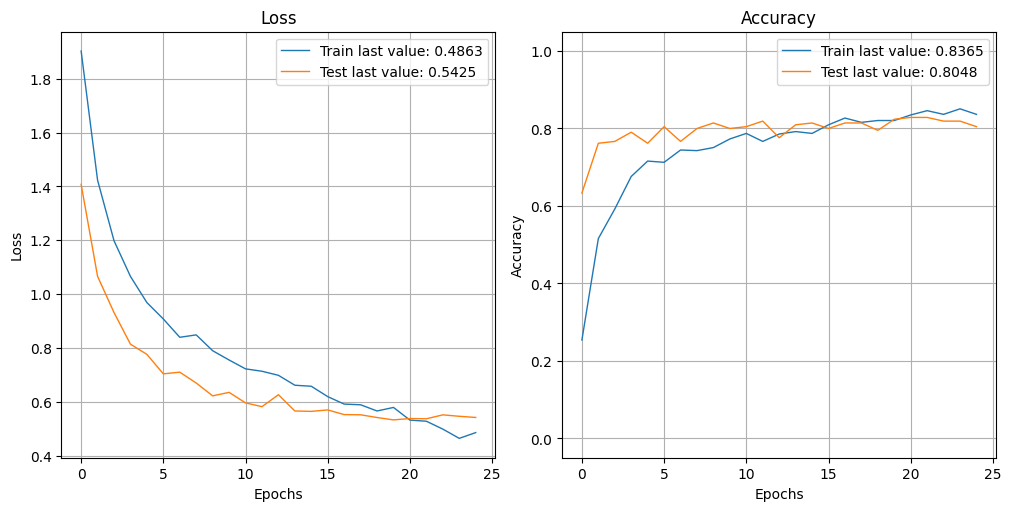

In [33]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

Le data augmentation a permis de réduire fortement le sur-apprentissage tout en augmentant légèrement les performances du modèle.